In [2]:
import os

os.environ['NUMBA_NUM_THREADS'] = '8'
os.environ['NUMBA_THREADING_LAYER'] = 'omp' # my TBB version complains
os.environ['NUMBA_ENABLE_AVX'] = '1'


import numpy as np
from pylab import *
from craco.cardcap import CardcapFile
from astropy.io import fits
from craco.card_averager import Averager
from craco.cardcapmerger import CcapMerger
import glob
import numba

from numba import jit,njit,prange


%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
nt = 64
nbeam = 36
nbl = 465
nant = 30
nfpga = 6
nc = 4*nfpga
npol = 2


In [4]:
def find_instr(func, keyword, sig=0, limit=5):
    count = 0
    for l in func.inspect_asm(func.signatures[sig]).split('\n'):
        if keyword in l:
            count += 1
            print(l)
            if count >= limit:
                break
    if count == 0:
        print('No instructions found')

In [5]:
cardfiles = glob.glob('/data/craco/ban115/craco-python/notebooks/data/SB43128/run3/1934_b07_c01+f?.fits')
assert len(cardfiles) == 6

cfiles = [CardcapFile(f) for f in cardfiles]
merger = CcapMerger(cardfiles)
fid, blk = next(merger.block_iter())

fileblocks = [next(f.packet_iter(nt*4*nbeam)) for f in cfiles]


In [6]:
len(fileblocks[0])

9216

In [7]:
fb0 = fileblocks[0]
fb0_block = fb0[:nt]

In [8]:
#numba.set_num_threads(3)
#numba.get_num_threads()

In [9]:
avg = Averager(nbeam, nant,nc,nt,npol)


In [10]:
from craco.card_averager import do_accumulate, accumulate_all

for i in range(10):
    do_accumulate(avg.output, avg.rescale_scales, avg.rescale_stats, avg.count, avg.nant, 0,0,fb0_block, 2, 6)
%timeit do_accumulate(avg.output, avg.rescale_scales, avg.rescale_stats, avg.count, avg.nant, 0,0,fb0_block, 2, 6)


572 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
gflops = nbl*npol*nt*(11)/300e-6/1e9
gflops

2.1824

In [12]:
do_accumulate.signatures

[(unaligned array(Record(ics[type=nestedarray(float32, (64, 24));offset=0],cas[type=nestedarray(float32, (64, 24));offset=6144],vis[type=nestedarray(complex64, (465, 4, 32));offset=12288];488448;False), 1d, C),
  array(float32, 4d, C),
  array(float32, 4d, C),
  int64,
  int64,
  int64,
  int64,
  unaligned array(Record(frame_id[type=uint64;offset=0],bat[type=uint64;offset=8],beam_number[type=uint8;offset=16],sample_number[type=uint8;offset=17],channel_number[type=uint8;offset=18],fpga_id[type=uint8;offset=19],nprod[type=uint16;offset=20],flags[type=uint8;offset=22],zero1[type=uint8;offset=23],version[type=uint32;offset=24],zero3[type=uint32;offset=28],data[type=nestedarray(int16, (1, 465, 2, 2));offset=32];3752;False), 1d, C),
  int64,
  int64)]

In [13]:
find_instr(do_accumulate, 'vadd') # holy crapsky - if there's a vadd instruction, it's SIMD vectorized

	vaddss	%xmm0, %xmm6, %xmm0
	vaddss	(%r15), %xmm5, %xmm0
	vaddss	6144(%rax,%rsi,8), %xmm3, %xmm0
	vaddss	6148(%rax,%rsi,8), %xmm4, %xmm1
	vaddss	%xmm6, %xmm1, %xmm1


In [14]:
fb0.dtype.isalignedstruct

False

In [15]:
#do_accumulate.parallel_diagnostics(level=4)

In [16]:
do_accumulate.inspect_types()

do_accumulate (unaligned array(Record(ics[type=nestedarray(float32, (64, 24));offset=0],cas[type=nestedarray(float32, (64, 24));offset=6144],vis[type=nestedarray(complex64, (465, 4, 32));offset=12288];488448;False), 1d, C), array(float32, 4d, C), array(float32, 4d, C), int64, int64, int64, int64, unaligned array(Record(frame_id[type=uint64;offset=0],bat[type=uint64;offset=8],beam_number[type=uint8;offset=16],sample_number[type=uint8;offset=17],channel_number[type=uint8;offset=18],fpga_id[type=uint8;offset=19],nprod[type=uint16;offset=20],flags[type=uint8;offset=22],zero1[type=uint8;offset=23],version[type=uint32;offset=24],zero3[type=uint32;offset=28],data[type=nestedarray(int16, (1, 465, 2, 2));offset=32];3752;False), 1d, C), int64, int64)
--------------------------------------------------------------------------------
# File: /data/craco/ban115/craco-python/src/craco/card_averager.py
# --- LINE 22 --- 

@njit(debug=True,fastmath=True,parallel=False, locals={'v0':real_dtype,

        

In [17]:
print(do_accumulate.inspect_asm(do_accumulate.signatures[0]))

	.text
	.file	"<string>"
	.section	.rodata.cst8,"aM",@progbits,8
	.p2align	3
.LCPI0_0:
	.quad	4607182418800017408
	.section	.rodata.cst4,"aM",@progbits,4
	.p2align	2
.LCPI0_1:
	.long	1073741824
	.text
	.globl	_ZN5craco13card_averager17do_accumulate$241E5ArrayI6RecordILi820EELi1E1C7mutable9unalignedE5ArrayIfLi4E1C7mutable7alignedE5ArrayIfLi4E1C7mutable7alignedExxxx5ArrayI6RecordILi824EELi1E1C7mutable9unalignedExx
	.p2align	4, 0x90
	.type	_ZN5craco13card_averager17do_accumulate$241E5ArrayI6RecordILi820EELi1E1C7mutable9unalignedE5ArrayIfLi4E1C7mutable7alignedE5ArrayIfLi4E1C7mutable7alignedExxxx5ArrayI6RecordILi824EELi1E1C7mutable9unalignedExx,@function
_ZN5craco13card_averager17do_accumulate$241E5ArrayI6RecordILi820EELi1E1C7mutable9unalignedE5ArrayIfLi4E1C7mutable7alignedE5ArrayIfLi4E1C7mutable7alignedExxxx5ArrayI6RecordILi824EELi1E1C7mutable9unalignedExx:
.Lfunc_begin0:
	.file	1 "/data/craco/ban115/craco-python/src/craco/card_averager.py"
	.loc	1 22 0
	.cfi_startproc
	pushq	%rbp
	.cfi_de

In [27]:
numba.set_num_threads(8)
from craco.card_averager import accumulate_all
avg.accumulate_all(fileblocks )

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../src/craco/card_averager.py", line 102:
#@njit(fastmath=True, parallel=True)
def accumulate_all(output, rescale_scales, rescale_stats, count, nant, beam_data, vis_fscrunch=1, vis_tscrunch=1):
^

  state.func_ir.loc))
/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'beam_data' of function 'accumulate_all'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-f

In [30]:
%timeit avg.accumulate_all(fileblocks )

79.8 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


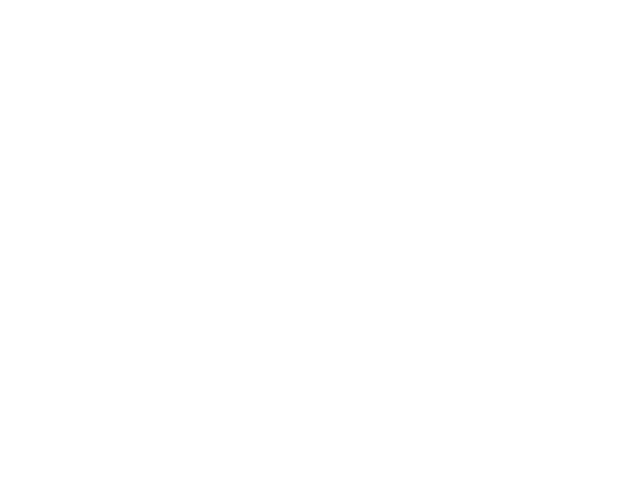

<IPython.core.display.Javascript object>


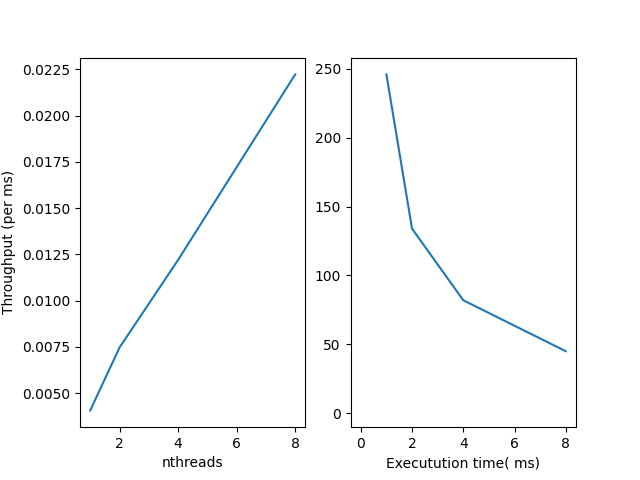

Text(0.5, 0, 'Executution time( ms)')

In [23]:
nthreads = [1,2,4,8]
time_ms = np.array([246, 134, 82, 45])
figure()
fig,ax = subplots(1,2)
ax[0].plot(nthreads, 1/time_ms)
ax[0].set_xlabel('nthreads')
ax[0].set_ylabel('Throughput (per ms)')
ax[1].plot(nthreads, time_ms)
ax[1].set_xlabel('nthreads')
ax[1].set_xlabel('Executution time( ms)')



In [ ]:
#nt = 64
#nbeam = 36
#nbl = 465
#nant = 30
#nfpga = 6
#nc = 4*nfpga
#npol = 2
# gflops per core
gflops=nbeam*npol*nc*nbl*nt*10/74e-3/float(numba.get_num_threads())/1e9
gflops


In [ ]:
n = 1024*32
indtype=np.int16
dtype=np.int32
#dtype=np.int16
a = np.arange(n, dtype=indtype)
b = np.arange(n, dtype=indtype)
c = np.zeros(n, dtype=dtype)


In [ ]:
%timeit np.add(a,b,out=c)

In [ ]:
gflops = n/4.27e-6/1e9
gflops

In [ ]:
@njit(fastmath=True)
def myadd(a,b,c):
    for i in range(len(a)):
        c[i] = a[i]+b[i]
        
myadd(a,b,c)
%timeit myadd(a,b,c)

In [ ]:
find_instr(myadd, 'vadd')

1024 elements is about 2x lower gflops athan 1024x8 elements - I guess there's overheads or prefetching or something. int16 is about 3x faster than float32. Float32 usues 'vadd' with YMM register = AVX-256 (not 512??). But it looks like  5 Gflops/core is about the limit for float32, and maybe 10Gflops/core at int16 is about as good as you'll go.


| func | N | intype | outtype | runtime | gflops | vadd? | 
| ------| --| ----| ---------| ------| ---| ---|
| myadd | N=32*1024 | int32 | int32 | 5.16us |  6.35  | No |
| myadd | N=32*1024 | int16  | int16 | 3.09us | 10.6  | No |
| myadd | N = 32*1024 | float32 | float32 |  6.48 | 5.0  | Yes |
| myadd | N = 32*1024 | int16 | float32 |  7.3 | 4.4 | No |
| myadd | N = 32*1024 | int16 | int32 | 4.27 | 7.6  | No |

In [ ]:
v = np.arange(10, dtype=np.int16) + np.int16((1<<15) - 5)


In [ ]:
v = np.int32(32767)*np.int32(32767)
np.iinfo(np.int32)

(30, 30)

In [62]:
def sim_casics(nant, sigamp):
    cas = 0
    ics = 0
    nant = 30
    N = 1024
    noise = np.random.randn(nant) + 1j*np.random.randn(nant)
    sig = np.ones(nant) + 1j*0
    s = sigamp*sig + noise
    x = np.outer(s, s.T)
    x.shape
    for a1 in range(nant):
        for a2 in range(a1, nant):
            a = np.abs(x[a1, a2])
            if a1 == a2:
                ics += a
            else:
                cas += a*2
    
    return cas,ics

In [63]:
siglvls = (0, 0.1, 0.3, 1, 3)
niter = 1024*8
results= np.zeros((len(siglvls), niter,2))
nant = 30
for isig, siglvl in enumerate(siglvls):
    results[isig,...] = np.array([sim_casics(nant, siglvl) for i in range(niter)])
        

In [64]:
cas_rms = results[0,0,:].std()
ics_rms = results[0,1,:].std()
cas_scale = results[:,0,:]/cas_rms
ics_scale = results[:,0,:]/ics_rms
cas_scale.mean(axis=1).shape


(5,)

<IPython.core.display.Javascript object>


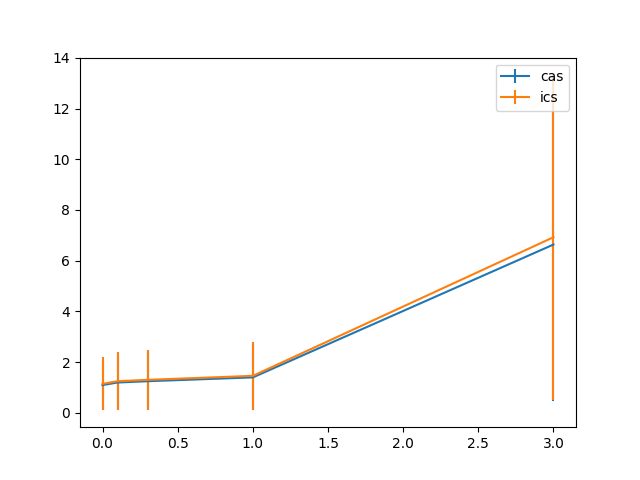

In [65]:


figure()
errorbar(siglvls, cas_scale.mean(axis=1), yerr=cas_scale.std(axis=1), label='cas')
errorbar(siglvls, ics_scale.mean(axis=1), yerr=ics_scale.std(axis=1), label='ics')

legend()